# MMTL Basics Tutorial

The purpose of this tutorial is to introduce the basic classes and flow of the MMTL package within Snorkel MeTaL (not necessarily to motivate or explain multi-task learning at large; we assume prior experience with MTL). For a broader understanding of the general Snorkel pipeline and Snorkel MeTaL library, see the `Basics` tutorial. In this notebook, we'll look at a simple MTL model with only two tasks, each having distinct data and only one set of labels (the ground truth or "gold" labels).

The primary purpose of the MMTL package is to enable flexible prototyping and experimentation in what we call the _massive multi-task learning_ setting, where we have large numbers of tasks and labels of varying types, granularities, and label accuracies. A major requirement of this regime is the ability to easily add or remove new datasets, new label sets, new tasks, and new metrics. Thus, in the MMTL package, each of these concepts have been decoupled. 

## Environment Setup

We first need to make sure that the `metal/` directory is on our Python path. If the following cell runs without an error, you're all set. If not, make sure that you've installed `snorkel-metal` with pip or that you've added the repo to your path if you're running from source; for example, running `source add_to_path.sh` from the repository root.

In [1]:
# Confirm we can import from metal
import sys
sys.path.append('../../metal')
import metal

# Import other dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set random seed for notebook
SEED = 123

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Toy Dataset

We'll now create a toy dataset to work with.
Our data points are 2D points in the square with edge length 2 centered on the origin.
Our tasks will be classifying whether these points are:

1. Inside a unit circle centered on the origin
2. Inside a unit square centered on the origin

We'll visualize these decision boundaries in a few cells.

In [3]:
import torch
torch.manual_seed(SEED)

N = 500  # Data points per dataset
R = 1    # Unit distance

# Dataset 0
X0 = torch.rand(N, 2) * 2 - 1
Y0 = (X0[:,0]**2 + X0[:,1]**2 < R).long()

# Dataset 1
X1 = torch.rand(N, 2) * 2 - 1
Y1 = ((-0.5 < X1[:,0]) * (X1[:,0] < 0.5) * (-0.5 < X1[:,1]) * (X1[:,1] < 0.5)).long()

Note that, as is the case throughout the Snorkel MeTaL repo, the label 0 is reserved for abstaining/no label; all actual labels have values greater than 0. This provides flexibility for supervision sources to label only portions of a dataset, for example. Thus, we'll convert our labels from being (1 = positive, 0 = negative) to (0=abstain, 1 = positive, 2 = negative).

In [4]:
from metal.utils import convert_labels

Y0 = convert_labels(Y0, "onezero", "categorical")
Y1 = convert_labels(Y1, "onezero", "categorical")

We use our utility funtion `split_data()` to divide this synthetic data into train/valid/test splits.

In [5]:
from metal.utils import split_data

X0_splits, Y0_splits = split_data(X0, Y0, splits=[0.8, 0.1, 0.1], seed=SEED)
X1_splits, Y1_splits = split_data(X1, Y1, splits=[0.8, 0.1, 0.1], seed=SEED)

And we view can view the ground truth labels of our tasks visually to confirm our intuition on what the decision boundaries look like.

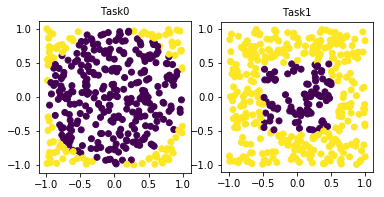

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)

axs[0].scatter(X0_splits[0][:,0], X0_splits[0][:,1], c=Y0_splits[0])
axs[0].set_aspect('equal', 'box')
axs[0].set_title('Task0', fontsize=10)

axs[1].scatter(X1_splits[0][:,0], X1_splits[0][:,1], c=Y1_splits[0])
axs[1].set_aspect('equal', 'box')
axs[1].set_title('Task1', fontsize=10)

print()

## Define MMTL Components

Now we'll define the core components of an MMTL problem: `Tasks`, `Models`, and `Payloads`.

### Tasks & MetalModels

A `Task` is a path through a network. In MeTaL, this corresponds to a particular sequence of Pytorch modules that each instance will pass through, ending with a "task head" module that outputs a prediction for that instance on that task. `Task` objects are not necessarily tied to a particular set of instances (data points) or labels.

In addition to specifying a path through the network, each task specifies which loss function and metrics it supports. You can look at the documentation for the `Task` class to see how to use custom losses or metrics; for now, we'll use the basic built-in `ClassificationTask` that uses cross-entropy loss and calculates accuracy.

The `MetalModel` is constructed from a set of `Tasks`. It constructs a network by stitching together the modules provided in each `Task`. In a future version of MeTaL, arbitrary DAG-like graphs of modules will be supported. In the present version, each `Task` can specify an input module, middle module, and head module (any module that is not provided will become an `IdentityModule`, which simply passes the data through with no modification).

The most common structure for MTL networks is to have a common trunk (e.g., input and/or middle modules) and separate heads (i.e., head modules). We will follow that design in this tutorial, making a feedforward network with 2 shared layers and separate task heads for each task. Each module can be composed of multiple submodules, so to accomplish this design, we can either include two linear layers in our input module, or assign one to the input module and one to the middle module; we arbitrarily use the former here.

In [7]:
from metal.mmtl.task import ClassificationTask

input_module = nn.Sequential(
    torch.nn.Linear(2, 8), 
    nn.ReLU(), 
    torch.nn.Linear(8, 4), 
    nn.ReLU()
)

# Note that both tasks are initialized with the same copy of the input_module
# This ensures that those parameters will be shared (rather than creating two separate input_module copies)
task0 = ClassificationTask(
    name="CircleTask", 
    input_module=input_module, 
    head_module=torch.nn.Linear(4, 2)
)

task1 = ClassificationTask(
    name="SquareTask", 
    input_module=input_module, 
    head_module=torch.nn.Linear(4, 2)
)

We now create the `MetalModel` from our list of tasks. 

In [8]:
from metal.mmtl import MetalModel

tasks = [task0, task1]
model = MetalModel(tasks, verbose=False)

### Payloads (Instances & Label Sets)

Now we'll define our `Payloads`. 

A `Payload` is a bundle of instances (data points) and one or more corresponding label sets. 
Each `Payload` contains data from only one split of the data (i.e., train data and test data should never touch).
Because we have two datasets with disjoint instance sets and three splits per dataset, we will make a total of six `Payloads`.

The instances in a `Payload` can consist of multiple fields of varied types (e.g., an image component and a text component for a caption generation task), and each `Payload` can contain multiple label sets (for example, if the same set of instances has labels for more than one task). If the instances have only one field and one label set, then you can use the helper method Payload.from_tensors(). In this case, the data you pass in (in our case, X) will be stored under the field name "data" by default and the label set will be given the name "labels" by default. See the other MMTL tutorial(s) for examples of problems where the data requires multiple fields or the instances have labels from multiple label sets.

Each `Payload` stores a dict that maps each label set to the task that it corresponds to.

In [9]:
from pprint import pprint
from metal.mmtl.payload import Payload

payloads = []
splits = ["train", "valid", "test"]
for i, (X_splits, Y_splits) in enumerate([(X0_splits, Y0_splits), (X1_splits, Y1_splits)]):
    for X, Y, split in zip(X_splits, Y_splits, splits):
        payload_name = f"Payload{i}_{split}"
        task_name = tasks[i].name
        payload = Payload.from_tensors(payload_name, X, Y, task_name, split, batch_size=32)
        payloads.append(payload)
        
pprint(payloads)

[Payload(Payload0_train: labels_to_tasks=[{'labels': 'CircleTask'}], split=train),
 Payload(Payload0_valid: labels_to_tasks=[{'labels': 'CircleTask'}], split=valid),
 Payload(Payload0_test: labels_to_tasks=[{'labels': 'CircleTask'}], split=test),
 Payload(Payload1_train: labels_to_tasks=[{'labels': 'SquareTask'}], split=train),
 Payload(Payload1_valid: labels_to_tasks=[{'labels': 'SquareTask'}], split=valid),
 Payload(Payload1_test: labels_to_tasks=[{'labels': 'SquareTask'}], split=test)]


## Train Model

The MetalModel is built from a list of `Task` objects.

When the network is printed, it displays one input/middle/head module for each `Task`, (even if multiple `Tasks` share the same module). We can also see that each module is wrapped in a DataParallel() layer (to enable parallelization across multiple GPUs when available) and MetalModuleWrappers (which wrap arbitrary Pytorch modules to ensure that they maintain the proper input/output formats that MeTaL expects. This output is often quite long, so we generally set `verbose=False` when constructing the model. 

In a future version update, more flexibility will be provided for specifying arbitrary DAG-like networks of modules between tasks.

In [ ]:
model = MetalModel(tasks, verbose=False)

To train the model, we create a `MultiTaskTrainer`. 
The default scheduling strategy in MeTaL is to pull batches from `Payloads` proportional to the number of batches they contain relative to the total number of batches; this is approximately equivalent to dividing all `Payloads` into batches at the beginning of each epoch, shuffling them, and then operating over the shuffled list sequentially.

In [30]:
from metal.mmtl.trainer import MultitaskTrainer

trainer = MultitaskTrainer()

The `train_model()` method requires a `MetalModel` to train, and payloads with data and labels to run through the model. 
Note once again that the data is separate from the tasks and model; the same model could be trained using payloads belonging to a different dataset, for example.

**Task-specific metrics are recorded in the form "task/payload/label_set/metric" corresponding to the task the made the predictions, the payload (data) the predictions were made on, the label set used to score the predictions, and the metric being calculated.**

For model-wide metrics (such as the total loss over all tasks or the learning rate), the default task name is `model`, the payload name is the name of the split, and the label_set is `all`.

In [31]:
scores = trainer.train_model(
    model, 
    payloads, 
    n_epochs=20, 
    log_every=2,
    lr=0.02, 
    progress_bar=False,
)

Beginning train loop.
Expecting approximately 832 examples total and 26 batches per epoch from 2 payload(s) in the train split.
[2.0 epo]:
  SquareTask:[Payload1_train/labels/loss=6.16e-02, Payload1_valid/labels/accuracy=9.60e-01]
  CircleTask:[Payload0_train/labels/loss=9.68e-02, Payload0_valid/labels/accuracy=9.60e-01]
  model:[train/all/loss=7.92e-02, train/all/lr=2.00e-02]
[4.0 epo]:
  CircleTask:[Payload0_train/labels/loss=7.77e-02, Payload0_valid/labels/accuracy=9.20e-01]
  SquareTask:[Payload1_train/labels/loss=6.83e-02, Payload1_valid/labels/accuracy=9.60e-01]
  model:[train/all/loss=7.30e-02, train/all/lr=2.00e-02]
[6.0 epo]:
  CircleTask:[Payload0_train/labels/loss=1.02e-01, Payload0_valid/labels/accuracy=9.80e-01]
  SquareTask:[Payload1_train/labels/loss=7.09e-02, Payload1_valid/labels/accuracy=9.40e-01]
  model:[train/all/loss=8.63e-02, train/all/lr=2.00e-02]
[8.0 epo]:
  CircleTask:[Payload0_train/labels/loss=1.14e-01, Payload0_valid/labels/accuracy=9.80e-01]
  SquareTask:

To calculate predictions or probabilities for an individual payload, we can then use the provided `MetalModel` methods.

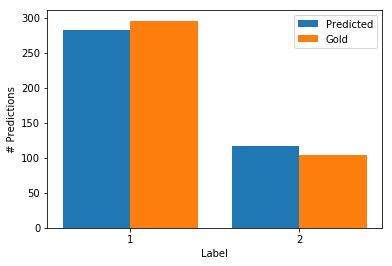

Plotting probabilities from the first column of Y_probs


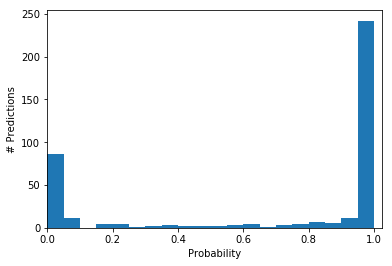

In [33]:
from metal.contrib.visualization.analysis import *

Y_probs = np.array(model.predict_probs(payloads[0]))
Y_preds = np.array(model.predict(payloads[0]))
Y_gold = payloads[0].data_loader.dataset.Y_dict["labels"].numpy()

plot_predictions_histogram(Y_preds, Y_gold)
plot_probabilities_histogram(Y_probs)

This concludes the MMTL Basics Tutorial.
To see a more advanced use case, see the MMTL BERT Tutorial.